# Frequentism and Bayesianism IV: How to be a Bayesian in Python

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

*This post is part of a 5-part series: [Part I](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)  [Part II](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/)  [Part III](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)  [Part IV](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) [Part V](http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/)*

*See also [Frequentism and Bayesianism: A Python-driven Primer](http://arxiv.org/abs/1411.5018), a peer-reviewed article partially based on this content.*

<!-- PELICAN_BEGIN_SUMMARY -->

I've been spending a lot of time recently writing about frequentism and Bayesianism.

- In [Frequentism and Bayesianism I: a Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) I gave an introduction to the main philosophical differences between frequentism and Bayesianism, and showed that for many common problems the two methods give basically the same point estimates.
- In [Frequentism and Bayesianism II: When Results Differ](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) I went into a bit more depth on when frequentism and Bayesianism start to diverge, particularly when it comes to the handling of nuisance parameters.
- In [Frequentism and Bayesianism III: Confidence, Credibility, and why Frequentism and Science Don't Mix](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/) I talked about the subtle difference between frequentist confidence intervals and Bayesian credible intervals, and argued that in most scientific settings frequentism answers the wrong question.

Here I want to back away from the philosophical debate and go back to more practical issues: in particular, demonstrating how you can apply these Bayesian ideas in Python. The workhorse of modern Bayesianism is the [Markov Chain Monte Carlo](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC), a class of algorithms used to efficiently sample posterior distributions.

Below I'll explore three mature Python packages for performing Bayesian analysis via MCMC:

- [emcee](http://dan.iel.fm/emcee): the MCMC Hammer
- [pymc](http://pymc-devs.github.io/pymc/): Bayesian Statistical Modeling in Python
- [pystan](https://pystan.readthedocs.org/en/latest/): The Python Interface to Stan

I won't be so much concerned with speed benchmarks between the three, as much as a comparison of their respective APIs. This post is not meant to be a tutorial in any of the three; each of them is well documented and the links above include introductory tutorials for that purpose. Rather, what I want to do here is a side-by-side comparison which will give a feel for how each package is used.  I'll propose a single relatively non-trivial test problem, and show the implementation and results of this problem using all three packages. Hopefully by seeing the three approaches side-by-side, you can choose which package might be best suited for your particular application.

<!-- PELICAN_END_SUMMARY -->

## Test Problem: Line of Best Fit

For our test problem, we'll do a three-parameter model which fits a straight line to data. The parameters will be the slope, the intercept, and the scatter about the line; the scatter in this case will be treated as a nuisance parameter.

### The Data

Let's define some data that we'll work with:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

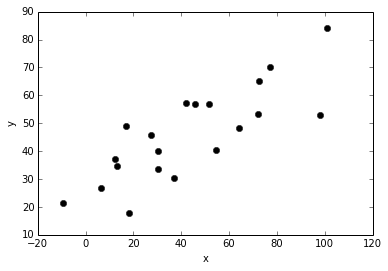

In [2]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

The data are clearly correlated, and we'll assume that we don't know the errors. Let's construct a linear model to fit this data.

### The Model: Slope, Intercept, & Unknown Scatter

Recall that Bayes' theorem gives

$$
P(\theta~|~D) \propto P(D~|~\theta) P(\theta)
$$

Where $D$ represents the observed data, and $\theta$ represents the model.

We'll assume a linear model for our data, parametrized by a slope $\beta$ and a y-intercept $\alpha$:

$$
\hat{y}(x_i~|~\alpha,\beta) = \alpha + \beta x_i
$$

Assuming gaussian errors on the observed y values, the probability for any data point under this model is given by:

$$
P(x_i, y_i~|~\alpha, \beta, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[\frac{-[y_i - \hat{y}(x_i~|~\alpha, \beta)]^2}{2\sigma^2}\right]
$$

where $\sigma$ here is an unknown measurement error, which we'll treat as a nuisance parameter

Multiplying these for all $i$ gives the likelihood:
$$
P(\{x_i\}, \{y_i\}~|~\alpha, \beta, \sigma) \propto (2\pi\sigma^2)^{-N/2} \exp\left[- \frac{1}{2\sigma^2} \sum_{i-1}^N [y_i - \hat{y}(x_i~|~\alpha,\beta)]^2\right]
$$

### The Prior

Here we're going to be a bit more careful about the choice of prior than we've been in the previous posts. We could simply choose flat priors on $\alpha$, $\beta$, and $\sigma$, but we must keep in mind that **flat priors are not always uninformative priors!** A better choice is to follow Jeffreys and use symmetry and/or maximum entropy to choose maximally noninformative priors. This is the kind of exercise in choosing priors is one that frequentists often complain about as overly subjective, but the approach is well-founded and very well-supported from an information theoretic standpoint.

Why might a flat prior a bad choice? This is perhaps easiest to see in the case of slope.  Let's visualize this by plotting some lines with slopes evenly-spaced between 0 and 10:

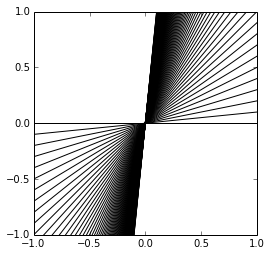

In [3]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
x = np.linspace(-1, 1)

for slope in np.arange(0, 10, 0.1):
    plt.plot(x, slope * x, '-k')

ax.axis([-1, 1, -1, 1], aspect='equal');

These lines have evenly-spaced slopes in units of 0.1, yet the higher slopes are bunched together. With a flat prior, you're essentially saying that any one of these slopes is just as likely as another. Due to this bunching seen above, it's clear that a flat prior on slope will highly favor very steep slopes!  A flat prior on slope is not a minimally informative prior, and may end up biasing your result (though with enough data the effect is almost zero).

You might imagine coming up with a better scheme by-hand (perhaps use a flat prior on the angle $\theta$ between the line and the x-axis) but we can be even more rigorous.  The following problem has been well-explored in the Bayesian literature; the best resource I've found is a paper by Jaynes: *Straight Line Fitting: A Bayesian Solution* [(pdf)](http://exordio.qfb.umich.mx/archivos%20pdf%20de%20trabajo%20umsnh/aphilosofia/bayesian%20importantes/leapz.pdf)

#### Prior on Slope and Intercept

If our model is given by

$$
y = \alpha + \beta x
$$

then we can construct a parameter-space probability element $P(\alpha, \beta) ~d\alpha ~d\beta$.

Because $x$ and $y$ are symmetric, we could just as easily use another set of parameters

$$
x = \alpha^\prime + \beta^\prime y
$$

with probability element $Q(\alpha^\prime, \beta^\prime)d\alpha^\prime d\beta^\prime$, where it's easy to show that

$$
(\alpha^\prime,~\beta^\prime) = (- \beta^{-1}\alpha,~\beta^{-1}).
$$

From the Jacobian of the transformation, we can show that

$$
Q(\alpha^\prime, \beta^\prime) = \beta^3 P(\alpha, \beta).
$$

Maintaining the symmetry of the problem requires that this change of variables should not affect the prior probability, so we can write:

$$
\beta^3 P(\alpha, \beta) = P(- \beta^{-1}\alpha, \beta^{-1}).
$$

This is a functional equation which is satisfied by

$$
P(\alpha, \beta) \propto (1 + \beta^2)^{-3/2}.
$$

which is equivalent to saying that $\alpha$ is uniformly distributed, and $\beta$ is distributed uniformly in $\sin\theta$ where $\theta = \tan^{-1}\beta$.

This might surprise you that the slopes are distributed according to $\sin\theta$ rather than uniformly in $\theta$. This $\sin\theta$ term, though, can actually be thought of as coming from the intercept!  If we change variables from $\alpha$ to $\alpha_\perp = \alpha\cos\theta$, then it's straightforward to show that our variables are uniformly distributed in $(\alpha_\perp,~\theta)$. We'll make use of this fact in the PyStan solution below.

#### Prior on $\sigma$

Similarly, we want the prior on $\sigma$ to be invariant to rescalings of the problem (i.e. changing units). So our probability must satisfy

$$
P(\sigma)d\sigma = P(\sigma / c)d\sigma / c.
$$

This is a functional equation satisfied by 

$$
P(\sigma) \propto 1 / \sigma.
$$

This is known as the [Jeffreys Prior](http://en.wikipedia.org/wiki/Jeffreys_prior), after Harold Jeffreys.

#### Putting our Priors Together

Putting these together, we see that symmetry arguments have led to the following minimally informative prior on our model:

$$
P(\alpha, \beta, \sigma) \propto \frac{1}{\sigma}(1 + \beta^2)^{-3/2}
$$

As alluded to above, you could equivalently address this by using flat priors on transformed parameters, namely $(\alpha, \beta, \sigma) \to (\alpha_\perp, \theta, \log\sigma)$, but I personally think the symmetry/maximum entropy approach is cleaner and clearer – it also gives us a chance to demonstrate the definition of nontrivial custom priors within the three packages.

## Solving This Problem in Python

Now that we have the data, the likelihood, and the prior, let's show how to solve this problem in Python using emcee, PyMC, and PyStan. First, though, let's quickly define some convenience routines which will help us visualize the results:

In [4]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

Without further ado, let's do some MCMC.

## Emcee

The [emcee](http://dan.iel.fm/emcee/current/) package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer [Dan Foreman-Mackey](http://dan.iel.fm/). It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line

```
[~]$ pip install emcee
```

Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior. Here's how we solve the above problem with ``emcee``:

In [5]:
import emcee
print(emcee.__version__)

2.0.0


In [6]:
# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [7]:
# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [8]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 5.73 s, sys: 13 ms, total: 5.75 s
Wall time: 5.76 s
done


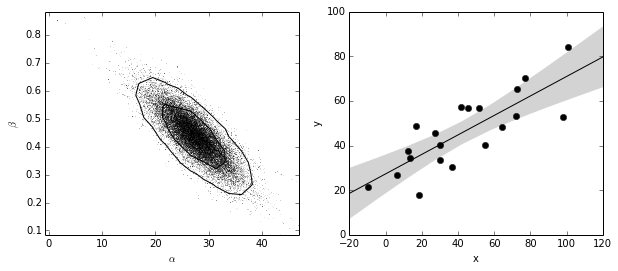

In [9]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(xdata, ydata, emcee_trace)

On the left we show the resulting traces marginalized over the nuisance parameter $\sigma$. On the right, we show the line of best-fit along with the 2-$\sigma$ uncertainty region. This is exactly the type of result we expect from MCMC: marginalized uncertainty contours around a model which provides a good by-eye fit to the data.

## PyMC

The [PyMC](http://pymc-devs.github.io/pymc/) package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. 
PyMC by default uses the classic [Metropolis-Hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. My machine has a working fortran compiler, so ``pip install pymc`` worked without a problem (but from working with students, colleagues, and tutorial attendees, I can tell you that few scientists today have a system setup such that this will work out-of-the-box). For folks who don't have a fortran compiler installed, PyMC binaries for many systems can be quite easily [installed with conda](https://conda.binstar.org/pymc).

I should mention that the future [PyMC version 3](https://github.com/pymc-devs/pymc) removes fortran dependence and makes the installation much more streamlined; I've also been told that the API of PyMC 3 is much cleaner, and that performance is much better. Because PyMC 3 is still listed as an alpha release, I've decided to stick with the current supported release for this post:

In [10]:
import pymc
print(pymc.__version__)

2.3


In [11]:
# Define the variables needed for the routine, with their prior distributions
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

@pymc.stochastic(observed=False)
def sigma(value=1):
    return -np.log(abs(value))

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, value=ydata)

# package the full model in a dictionary
model1 = dict(alpha=alpha, beta=beta, sigma=sigma,
              y_model=y_model, y=y)

In [12]:
# run the basic MCMC: we'll do 100000 iterations to match emcee above
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 17.1 sec

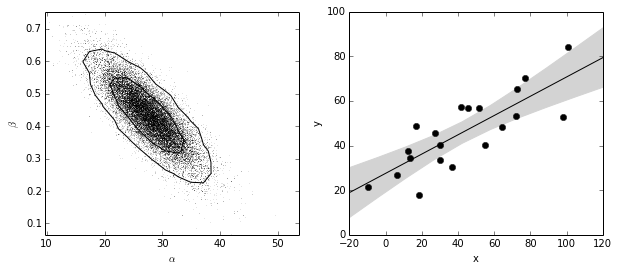

In [13]:
# extract the traces and plot the results
pymc_trace = [S.trace('alpha')[:],
              S.trace('beta')[:],
              S.trace('sigma')[:]]

plot_MCMC_results(xdata, ydata, pymc_trace)

We get traces very similar to those provided by emcee.

## PyStan

The [PyStan](http://mc-stan.org/pystan.html) project is the official Python wrapper of the [Stan](http://mc-stan.org/) Probabilistic programming language, which is implemented in C++. It uses a [No U-Turn Sampler](http://arxiv.org/abs/1111.4246), which is more sophisticated than classic Metropolis-Hastings or Gibbs sampling. As far as API goes, the important difference between PyStan as compared to emcee and PyMC is that it requires you to **write and compile non-Python code** within your Python script when defining your model.

Because PyStan depends on the Stan package, installation can be difficult. In particular, you need the full Stan library to be installed in order to use the python wrapper. If you have a well-set-up environment for compiling C/C++ code, this shouldn't be a problem – using ``pip install pystan`` downloaded, compiled, and installed everything necessary on my system.

From what I could find online, it doesn't appear that the Stan team provides pre-built binaries, including for conda. Because of this, if you don't have your system set up for C/C++ compilation, installation will probably be more difficult.

I'm using version 2.2 of PyStan:

In [14]:
import pystan
print(pystan.__version__)

2.2.0.1


There is one more hiccup with this package: for some reason, PyStan runs extremely slowly and crashes my computer when I run it in the IPython notebook itself, but works without issues when I run it as an executable Python file. I'm not sure why this is but it may have something to do with [this issue](https://github.com/stan-dev/pystan/issues/3).  To get around this, I'll save the PyStan script as a standalone Python file and execute it from the command-line, writing the resulting traces to disk:

In [15]:
%%file pystan_example.py

import numpy as np
import pystan

#---------------------------------------------
# Generate data (same as used in the notebook)

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

#----------------------------------------------
# Create the Stan model
#  this is done by defining a string of Stan code.

fit_code = """
data {
    int<lower=0> N; // number of points
    real x[N]; // x values
    real y[N]; // y values
}

parameters {
    real alpha_perp;
    real<lower=-pi()/2, upper=pi()/2> theta;
    real log_sigma;
}

transformed parameters {
    real alpha;
    real beta;
    real sigma;
    real ymodel[N];
    
    alpha <- alpha_perp / cos(theta);
    beta <- sin(theta);
    sigma <- exp(log_sigma);
    for (j in 1:N)
    ymodel[j] <- alpha + beta * x[j];
}

model {
    y ~ normal(ymodel, sigma);
}
"""

# perform the fit
fit_data = {'N': len(xdata), 'x': xdata, 'y': ydata}
fit = pystan.stan(model_code=fit_code, data=fit_data, iter=25000, chains=4)

# extract the traces
traces = fit.extract()
pystan_trace = [traces['alpha'], traces['beta'], traces['sigma']]

# save the traces with numpy
np.save("pystan_trace.npy", pystan_trace)

Overwriting pystan_example.py


In [16]:
# run the code we've created on the command-line
!python pystan_example.py

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1dba2ed7f485b674d7ce5eb738ffe05 NOW.
INFO:pystan:NOW ON CHAIN 0
INFO:pystan:NOW ON CHAIN 1
INFO:pystan:NOW ON CHAIN 2
INFO:pystan:NOW ON CHAIN 3
Iteration:     1 / 25000 [  0%]  (Warmup)
Informational Message: The current Metropolis proposal is about to be rejected becuase of the following issue:
Error in function stan::prob::normal_log(N4stan5agrad3varE): Scale parameter is 0:0, but must be > 0!
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Iteration: 25000 / 25000 [100%]  (Sampling)
Elapsed Time: 0.664267 seconds (Warm-up)
              0.724006 seconds (Sampling)
              1.38827 seconds (Total)

Iteration: 25000 / 25000 [100%]  (Sampling)
Elapsed Time: 0.6626 seconds (Warm-up)
              0.781297 seconds (Sampling)
            

As we can see, the execution takes ~6 sec in serial to draw 100,000 samples. Additionally, on my machine, the compilation phase takes about ~20 seconds before the model is run.

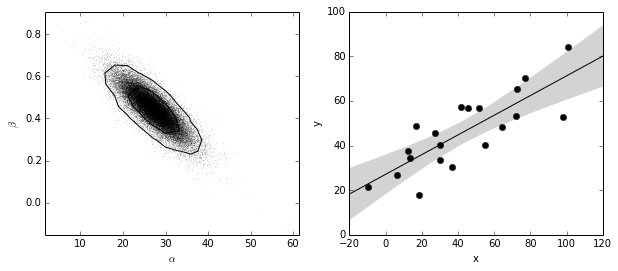

In [17]:
# load the results from file; plot as above
pystan_trace = np.load('pystan_trace.npy')
plot_MCMC_results(xdata, ydata, pystan_trace)

Again, the results look similar to what we've seen above.

## Summary: Comparing the Three Methods

As a more direct comparison of the results, let's quickly over-plot the contours derived by the three methods:

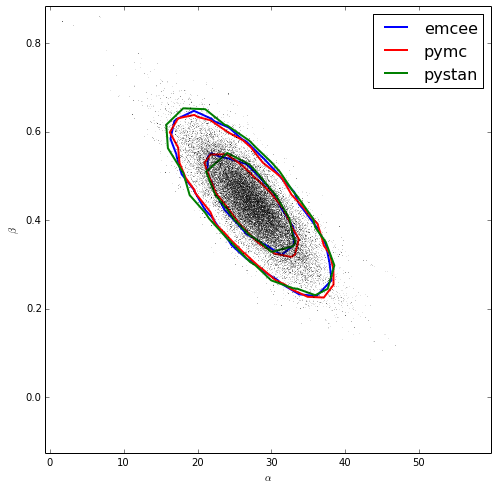

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_MCMC_trace(ax, xdata, ydata, emcee_trace, True,
                colors='blue', linewidths=2)
plot_MCMC_trace(ax, xdata, ydata, pymc_trace,
                colors='red', linewidths=2)
plot_MCMC_trace(ax, xdata, ydata, pystan_trace,
                colors='green', linewidths=2)
ax.legend(ax.collections[::2], ['emcee', 'pymc', 'pystan'], fontsize=16);

As we would expect, the results agree! This indicates that we've defined the models consistently in all three packages. Additionally, we see that the "true" values used to generate the distribution of points (25, 0.5) fall within the 1-$\sigma$ error ellipse.

### Evaluating the Packages

So which package is the best? The answer to that will likely depend on what your problem is. Here's a quick table summarizing my own impressions of the three packages:

<table>
<tr>
<th></th>
<th>Complexity</th>
<th>Execution time (100,000 samples; includes burn-in)</th>
<th>Ease of Installation</th>
<th>Learning Curve/Ease of Use</th>
<th>Number of Features</th>
</tr>

<tr>
<th>emcee</th>
<td bgcolor='#CCFFCC'>Very lightweight</td>
<td bgcolor='#CCFFCC'>~6 sec</td>
<td bgcolor='#CCFFCC'>Pure python; installs easily with pip</td>
<td bgcolor='#CCFFCC'>Straightforward & Pythonic</td>
<td bgcolor='#FFCCCC'>not much built-in beyond basic MCMC sampling</td>
</tr>

<tr>
<th>pymc2</th>
<td bgcolor='#FFFFCC'>Lots of functionality & options</td>
<td bgcolor="#FFCCCC">~17 sec</td>
<td bgcolor="#EEFFCC">Requires fortran compiler; binaries available via conda</td>
<td bgcolor="#FFFFCC">Pythonic, but lots of pymc-specific boilerplate</td>
<td bgcolor='#CCFFCC'>Lots of built-in functionality in Python</td>
</tr>

<tr>
<th>pystan</th>
<td bgcolor='#FFCCCC'>Large package; requires coding in Stan language</td>
<td bgcolor="#FFFFCC">~20 sec compilation + ~6 sec computation</td>
<td bgcolor="#FFCCCC">Requires C compiler + Stan installation; no binaries available</td>
<td bgcolor="#FFCCCC">Not pure Python; must learn Stan model specification language</td>
<td bgcolor='#EEFFCC'>Lots of built-in functionality in Stan-specific language</td>
</tr>

</table>

More verbosely:

**emcee** is extremely lightweight, and that gives it a lot of power. All you need to do is define your log-posterior (in Python) and emcee will sample from that distribution. Because it's pure-Python and does not have specially-defined objects for various common distributions (i.e. uniform, normal, etc.) I thought it might be slower than the others, but its performance on this problem is impressive. This is perhaps due to the more sophisticated default sampling scheme, so the benchmark may not be a fair comparison.

**pymc** is more full-featured, and once you get the hang of the decorator syntax for defining variables, distributions, and derived quantities, it is very easy to use. Its performance lagged the other two: the same query took several times longer, despite having optimized objects for sampling from various priors. From what I hear, though, the still-in-alpha PyMC version 3 – a complete rewrite of the package – blows PyMC version 2 out of the water.

**pystan** is the most difficult of the three to use, but that's because it's not really a Python package. Models are specified not in Python, but in a custom statistical expression language. This language is very powerful, but has a steep learning curve. The ~20sec compilation time for each model is annoying, but I suspect that as models get more complicated and sample sizes grow, this won't seem like such an issue. The fact that Stan is specifically designed for this type of operation, and the fact that all its models compile directly to byte code, makes it seem like a reasonable choice for large, specialized computations.

I wouldn't put much weight on the timings here; as mentioned above, the packages use very different default sampling schemes (Metropolis-Hastings for PyMC, no U-Turn sampling for PyStan, and affine-invariant ensemble sampling for emcee) so the times are not directly comparable. Each of these sampling schemes has its advantages and disadvantages, which you can read about in the links in above sections.

I hope that I've given a fair comparison of these packages here. Note that I'm not an expert or contributor to any of these packages: I've simply read the online documentation and adapted the tutorial examples to the specific problem I proposed here. If any power users or package developers are reading this and have feedback about how to better use or represent any of these packages, I'd love to hear your response! I'd say two things:

1. Please write a blog comment and let me know how to use your package more effectively!
2. Please realize that *the average user likely uses your package as I did here*: by reading the intro tutorials, and adapting those examples to their own problems. If that has led me to do something silly, it's likely that many of your users are making the same silly mistake!

Thanks for reading!

*This post was written entirely in the IPython notebook.  You can [download](http://jakevdp.github.io/downloads/notebooks/FreqBayes4.ipynb) this notebook, or see a static view on [nbviewer](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/FreqBayes4.ipynb).*